## Import relevant libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
sb.set_theme()

## Import data

In [2]:
HDB_data_master_copy = pd.read_csv('Resale_HDB_Data.csv')
HDB_data = HDB_data_master_copy.copy() # Making a copy so we preserve the original dataframe

In [3]:
HDB_data.head() # To see what we're working with

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


### Check dataset quality, as well as inspect the data types

In [4]:
HDB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174351 entries, 0 to 174350
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                174351 non-null  object 
 1   town                 174351 non-null  object 
 2   flat_type            174351 non-null  object 
 3   block                174351 non-null  object 
 4   street_name          174351 non-null  object 
 5   storey_range         174351 non-null  object 
 6   floor_area_sqm       174351 non-null  float64
 7   flat_model           174351 non-null  object 
 8   lease_commence_date  174351 non-null  int64  
 9   remaining_lease      174351 non-null  object 
 10  resale_price         174351 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 14.6+ MB


#### Remaining lease should be a numerical variable. We convert it below. 

In [5]:
def remaining_lease_in_years(row):
    if len(row) > 11:
        years, months = row.strip().split('years')[0], row.strip().split('years')[1].split('month')[0]
    else:
        years, months = row.strip().split('years')[0], 0
    return round(int(years) + int(months)/12,3)

HDB_data['remaining_lease'] = HDB_data['remaining_lease'].apply(remaining_lease_in_years)

HDB_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.583,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.417,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.083,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.417,265000.0


#### Let's see how remaining lease interacts with resale price

<Axes: xlabel='remaining_lease', ylabel='resale_price'>

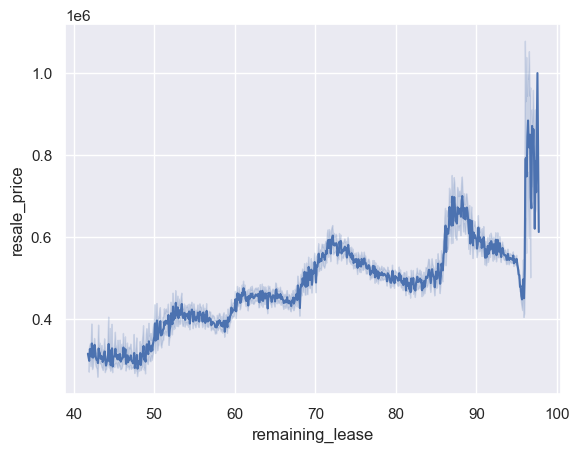

In [6]:
sb.lineplot(x='remaining_lease', y='resale_price', data=HDB_data)

#### It seems there are ranges where resale price stays relatively constant, so let's try to group remaining lease. A popular method to discretise a continuous variable is the Freedman-Diaconis Rule. 



In [7]:
remaining_lease = HDB_data['remaining_lease']

rem_lease_min = remaining_lease.min()
rem_lease_max = remaining_lease.max()
rem_lease_q3 = np.percentile(remaining_lease, 75)
rem_lease_q1 = np.percentile(remaining_lease, 25)
iqr = rem_lease_q3 - rem_lease_q1

bin_width = 2*iqr/(len(remaining_lease)**(1/3))
num_bins = int(np.ceil((rem_lease_max - rem_lease_min) / bin_width))
bin_edges = np.linspace(rem_lease_min, rem_lease_min + bin_width * num_bins, num=num_bins + 1)

bin_indices = np.digitize(HDB_data['remaining_lease'], bin_edges)
HDB_data['discretized_remaining_lease'] = bin_indices

HDB_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,discretized_remaining_lease
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333,232000.0,23
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.583,250000.0,22
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.417,262000.0,24
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.083,265000.0,23
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.417,265000.0,24


#### Domain knowledge suggests that we should normalise the resale price with the floor area. 

In [8]:
HDB_data['floor_area_normalised_price'] = HDB_data['resale_price'] / HDB_data['floor_area_sqm']

HDB_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,discretized_remaining_lease,floor_area_normalised_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333,232000.0,23,5272.727273
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.583,250000.0,22,3731.343284
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.417,262000.0,24,3910.447761
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.083,265000.0,23,3897.058824
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.417,265000.0,24,3955.223881


#### Next, let's see how prices change with time. It would be better to identify structures within our data when we remove any time-dependent price appreciation since we are working with multi-year data.

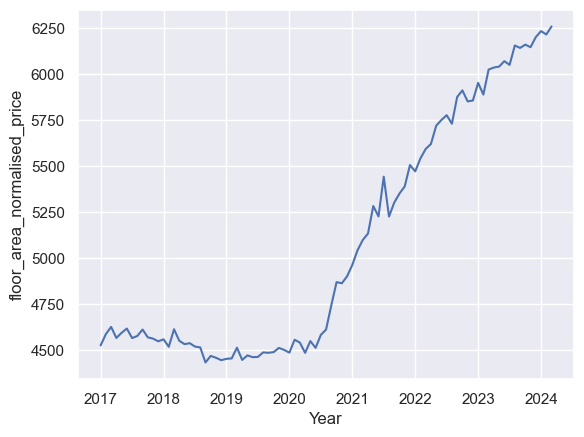

In [9]:
sb.lineplot(x='month', y='floor_area_normalised_price', data=HDB_data,errorbar=None)

# Customize x-axis ticks to show only the start of each year
years = pd.to_datetime(HDB_data['month']).dt.year.unique()
start_of_years = [f"{year}-01" for year in years]

plt.xticks(start_of_years, years);
plt.xlabel('Year');

#### It is evident that there are forms of price depreciation/appreciation in our data. Let's strive to remove that next. 

In [10]:
def year_from_month(row): # this function allows us to get the year given e.g. '2017-01' in 'month'
    year = row.split('-')[0] # specifying the delimiter as '-' and taking the values left of it
    return year

HDB_data['year_from_month'] = HDB_data['month'].apply(year_from_month)

def remove_price_appreciation(row):
    year = row['year_from_month']
    price = row['floor_area_normalised_price']
    return price/(1+annual_return[year])

# For better readability, let annual_avg_floor_area_normalised_resale_price = avgP

# Finding the annual average prices
avgP = HDB_data.groupby(['year_from_month'])['floor_area_normalised_price'].mean()

# Finding the annual (all time periods) return based on 2017 averages
annual_return = (avgP / avgP[0]) - 1

# Calculate the prices accounting for time factor
HDB_data['final_norm_price'] = HDB_data.apply(remove_price_appreciation, axis=1)
HDB_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,discretized_remaining_lease,floor_area_normalised_price,year_from_month,final_norm_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333,232000.0,23,5272.727273,2017,5272.727273
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.583,250000.0,22,3731.343284,2017,3731.343284
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.417,262000.0,24,3910.447761,2017,3910.447761
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62.083,265000.0,23,3897.058824,2017,3897.058824
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.417,265000.0,24,3955.223881,2017,3955.223881


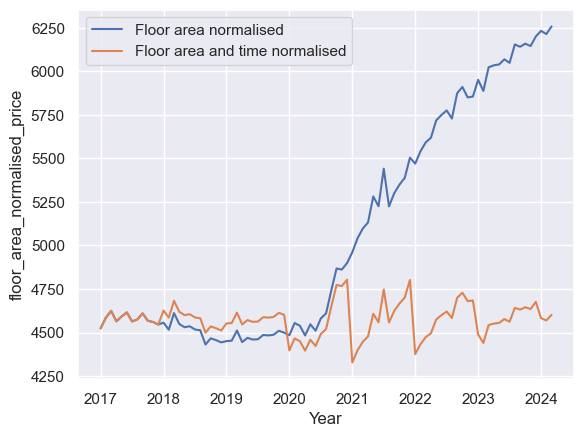

In [11]:
sb.lineplot(x='month', y='floor_area_normalised_price', data=HDB_data, label='Floor area normalised',errorbar=None)

years = pd.to_datetime(HDB_data['month']).dt.year.unique() # get unique years from 'month' column
start_of_years = [f"{year}-01" for year in years]

sb.lineplot(x='month', y='final_norm_price', data=HDB_data, label='Floor area and time normalised',errorbar=None)
plt.xticks(start_of_years, years) # positions set by 'start_of_years' and showing 'years' at those positions
plt.xlabel('Year');
plt.legend;

#### The objective is to predict the resale price. Let's see which variables we should use to predict. 

In [12]:
# Dropping columns that we no longer need
columns_to_drop = ['floor_area_sqm', 
                   'lease_commence_date', 
                   'remaining_lease', 
                   'resale_price', 
                   'floor_area_normalised_price', 
                   'year_from_month']

HDB_subdata = HDB_data.copy()
HDB_subdata = HDB_subdata.drop(columns=columns_to_drop)

HDB_subdata.head()

,month,town,flat_type,block,street_name,storey_range,flat_model,discretized_remaining_lease,final_norm_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,Improved,23,5272.727273
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,New Generation,22,3731.343284
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,New Generation,24,3910.447761
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,New Generation,23,3897.058824
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,New Generation,24,3955.223881


In [13]:
HDB_subdata.dtypes

month                           object
town                            object
flat_type                       object
block                           object
street_name                     object
storey_range                    object
flat_model                      object
discretized_remaining_lease      int64
final_norm_price               float64
dtype: object

#### Data types are wrong. Let's assign correct ones. 

In [14]:
cat_data = ['month',
            'town', 
            'flat_type', 
            'block', 
            'street_name', 
            'storey_range', 
            'flat_model', 
            'discretized_remaining_lease']

HDB_subdata[cat_data] = HDB_subdata[cat_data].astype('category')
HDB_subdata.dtypes

month                          category
town                           category
flat_type                      category
block                          category
street_name                    category
storey_range                   category
flat_model                     category
discretized_remaining_lease    category
final_norm_price                float64
dtype: object

#### Obtain descriptive statistics belonging to the final_norm_price column, which may be useful later

In [15]:
HDB_subdata['final_norm_price'].describe()

count    174351.000000
mean       4578.877692
std        1156.046484
min         662.395063
25%        3824.258768
50%        4285.931545
75%        4966.366156
max       12513.660441
Name: final_norm_price, dtype: float64

## Feature Selection for Algorithm

#### Possible X = town, flat_type, block, street_name, storey_range, flat_model, discretized_remaining_lease
#### Y = final_norm_price

#### Let's shortlist the X variables. 

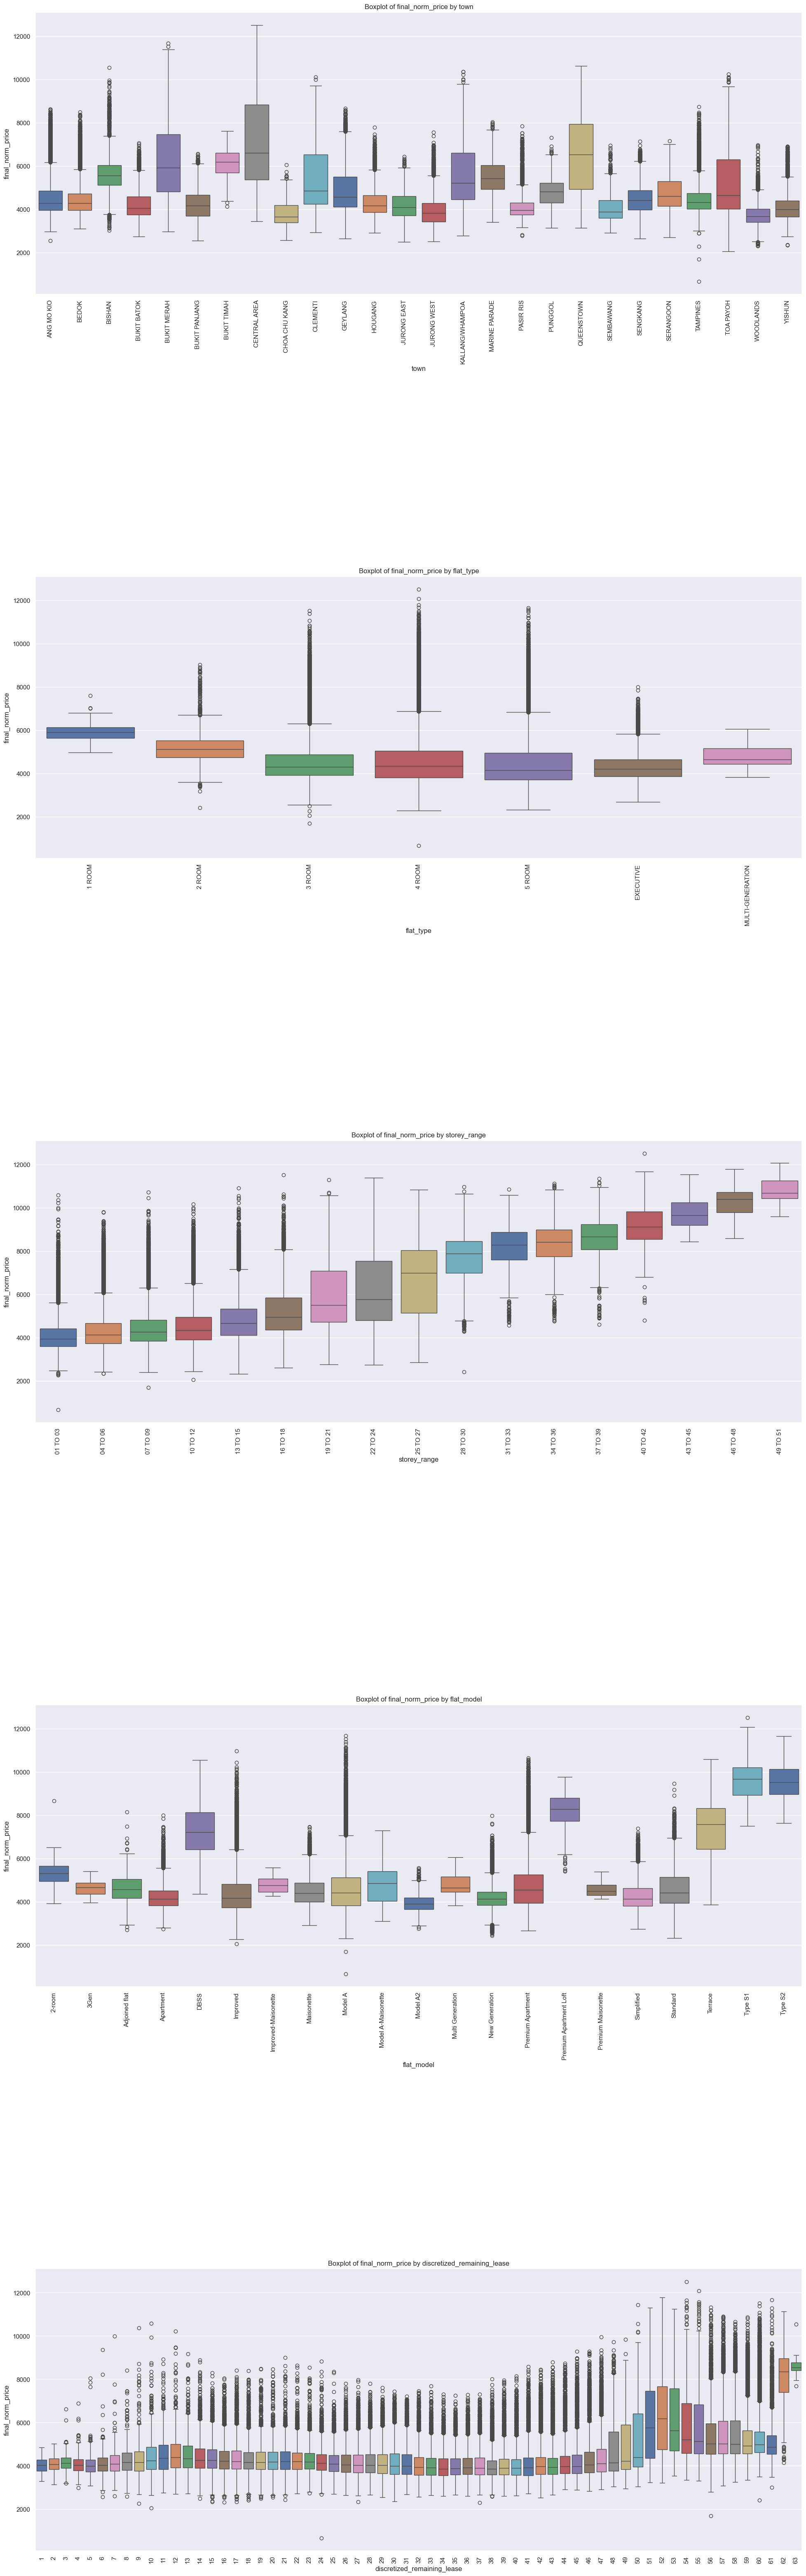

In [16]:
categories = ['town', 
              'flat_type', 
              'storey_range', 
              'flat_model', 
              'discretized_remaining_lease']

# Create a figure and subplots grid
fig, axes = plt.subplots(len(categories), 1, figsize=(24, 80)) # this line limits the size of size for all plots

# Loop through each variable in categories and create boxplots
for idx, category in enumerate(categories):
    ax = sb.boxplot(data=HDB_subdata, x=category, y='final_norm_price', ax=axes[idx],palette='deep')
    ax.set_ylabel('final_norm_price')
    ax.set_title(f'Boxplot of final_norm_price by {category}') # dynamic title
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) # plt.xtick(rotation=90) did not work

plt.subplots_adjust(hspace=1) # resolved overlap between subsequent charts and rotated x labels

#### It has become clear that town, storey_range, discretized_remaining_lease, flat_model, and flat_type has considerable impact on final_norm_price. 

#### The box plots for block and street_name is too cluttered to be beneficial to us. Let's plot with just the median. 

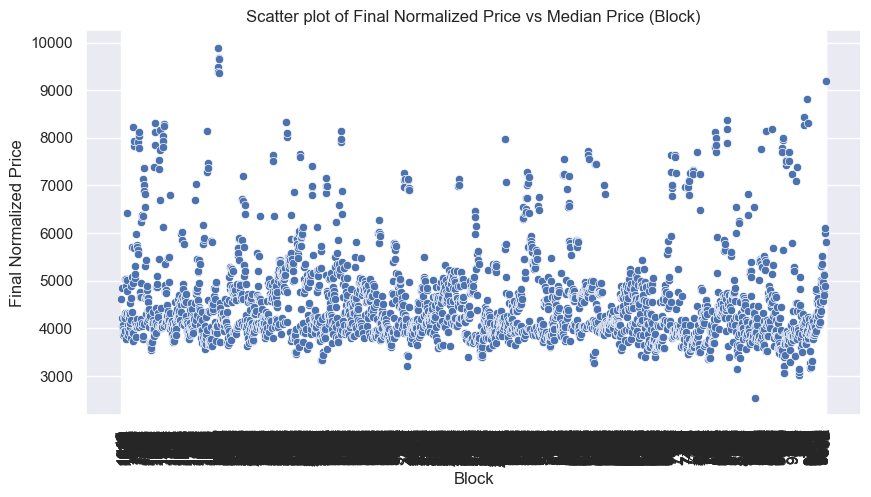

In [17]:
# Calculate median price for each block
median_price_block = HDB_subdata.groupby('block')['final_norm_price'].median().reset_index()

# Create scatter plot for price vs median price for each block
plt.figure(figsize=(10, 5))
sb.scatterplot(data=median_price_block, y='final_norm_price', x='block')
plt.ylabel('Final Normalized Price')
plt.xlabel('Block')
plt.title('Scatter plot of Final Normalized Price vs Median Price (Block)')
plt.xticks(rotation=90);

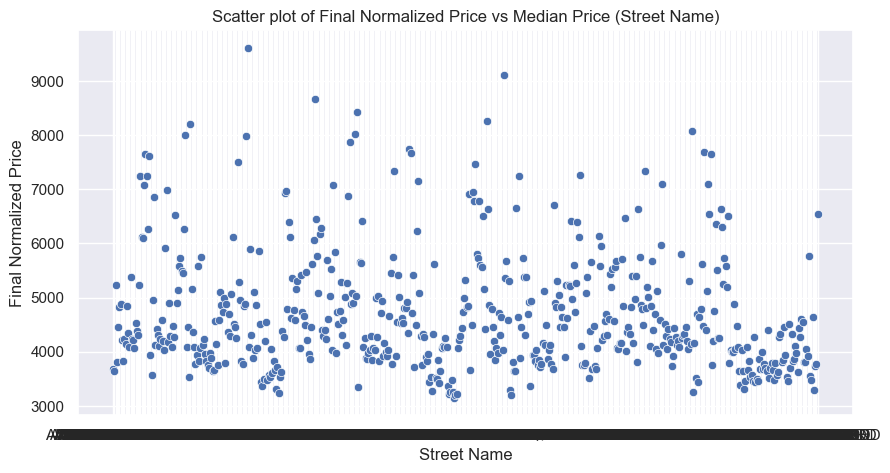

In [18]:
# Calculate median price for each street name
median_price_street = HDB_subdata.groupby('street_name')['final_norm_price'].median().reset_index()

# Create scatter plot for price vs median price for each street name
plt.figure(figsize=(10, 5))
sb.scatterplot(data=median_price_street, x='street_name', y='final_norm_price')
plt.xlabel('Street Name')
plt.ylabel('Final Normalized Price')
plt.title('Scatter plot of Final Normalized Price vs Median Price (Street Name)');

#### Based on the 2 charts above and domain knowledge, we've decided to drop block and street name as predictors. 
#### X variables chosen as predictors: 'town', 'flat_type','flat_model','storey_range','discretized_remaining_lease'
#### With data treatment and analysis done, let's conduct linear regression with the entire dataset, and analyse the findings

## Machine Learning Algorithm Application 

In [19]:
# Define X, y, and split into training and testing datasets. 

from sklearn.model_selection import train_test_split

y = pd.DataFrame(HDB_subdata['final_norm_price'])
X = pd.DataFrame(HDB_subdata[['town', 
                             'flat_type', 
                             'flat_model', 
                             'storey_range', 
                             'discretized_remaining_lease']]) 

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42) # 25% test

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (130763, 1) (130763, 5)
Test Set  : (43588, 1) (43588, 5)


#### We'll be encoding the categorical predictors in X as Decision Tree Regressor takes only boolean or continuous variables as input. Here, there is a different treatment to categorical predictors where order matters (i.e., storey range)-- please refer to the chart on price against storey range. 
#### We also understand that encoding categorical variables introduces the dummy variable trap: where groups within each categorical variable are perfectly correlated with each other. This is mitigated by dropping the first group that is encoded for each categorical variable.

In [20]:
# List of columns with categorical values which have non ordinal (where order doesn't matter)
categorical_columns = ['town','flat_type','flat_model']

# Perform simple dummy encoding for categorical columns in training set, using drop_first to account for dummy variable trap
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns,drop_first=True)

# Perform simple dummy encoding for categorical columns in testing set, using drop_first to account for dummy variable trap
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns,drop_first=True)

# Define a dictionary with columns and their corresponding order
ordinal_encoding_storey = {
    'storey_range': ['01 TO 03','04 TO 06','07 TO 09','10 TO 12','13 TO 15','16 TO 18','19 TO 21','22 TO 24','25 TO 27','28 TO 30','31 TO 33','34 TO 36','37 TO 39','40 TO 42','43 TO 45','46 TO 48','49 TO 51']
}

# Apply ordinal encoding for 'storey_range' column in both training and testing sets
for col, order in ordinal_encoding_storey.items():
    X_train_encoded[col + '_ordinal'] = X_train_encoded[col].apply(lambda x: order.index(x))
    X_test_encoded[col + '_ordinal'] = X_test_encoded[col].apply(lambda x: order.index(x))

# Drop the original 'storey_range' column from both training and testing sets
X_train_encoded.drop(columns='storey_range', inplace=True)
X_test_encoded.drop(columns='storey_range', inplace=True)

# Display the result
print("Train Set Encoded:", X_train_encoded.shape)
print("Test Set Encoded:", X_test_encoded.shape)

Train Set Encoded: (130763, 53)
Test Set Encoded: (43588, 53)


#### Next, we'll import the tool for machine learning and train the linear regression model.

In [21]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train_encoded, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)

Intercept of Regression 	: b =  [4064.34524633]
Coefficients of Regression 	: a =  [[   44.8892517   -103.26440189   771.79373672  -799.09014226
   1159.30192345 -1188.40541143  1652.67267906  1473.82899347
  -1476.86801342   376.14187766   447.13831619  -721.52316091
   -680.35071196 -1161.92456467   610.44878521  1481.68327429
   -836.63685655 -1142.98289197  1293.59367926 -1516.55297223
  -1262.7459398     41.47043991  -378.64838159   480.04176595
  -1384.7008929  -1042.54208832  -499.18277783  -781.90180171
   -932.58998556  -963.64354428 -1014.78747227  -119.36849567
   -331.30034379   273.15544833   222.1793765   1145.28375588
   -131.75501569  1373.88294618   477.22554247  -115.39723387
    643.7898863   -107.06659294  -119.36849567    35.01288426
     15.44261887   505.9291385    115.8121828    218.09656115
   -111.57980942  3033.29138775  1458.90827896  1451.16865339
    131.79828519]]


In [22]:
# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train_encoded)
y_test_pred = linreg.predict(X_test_encoded)

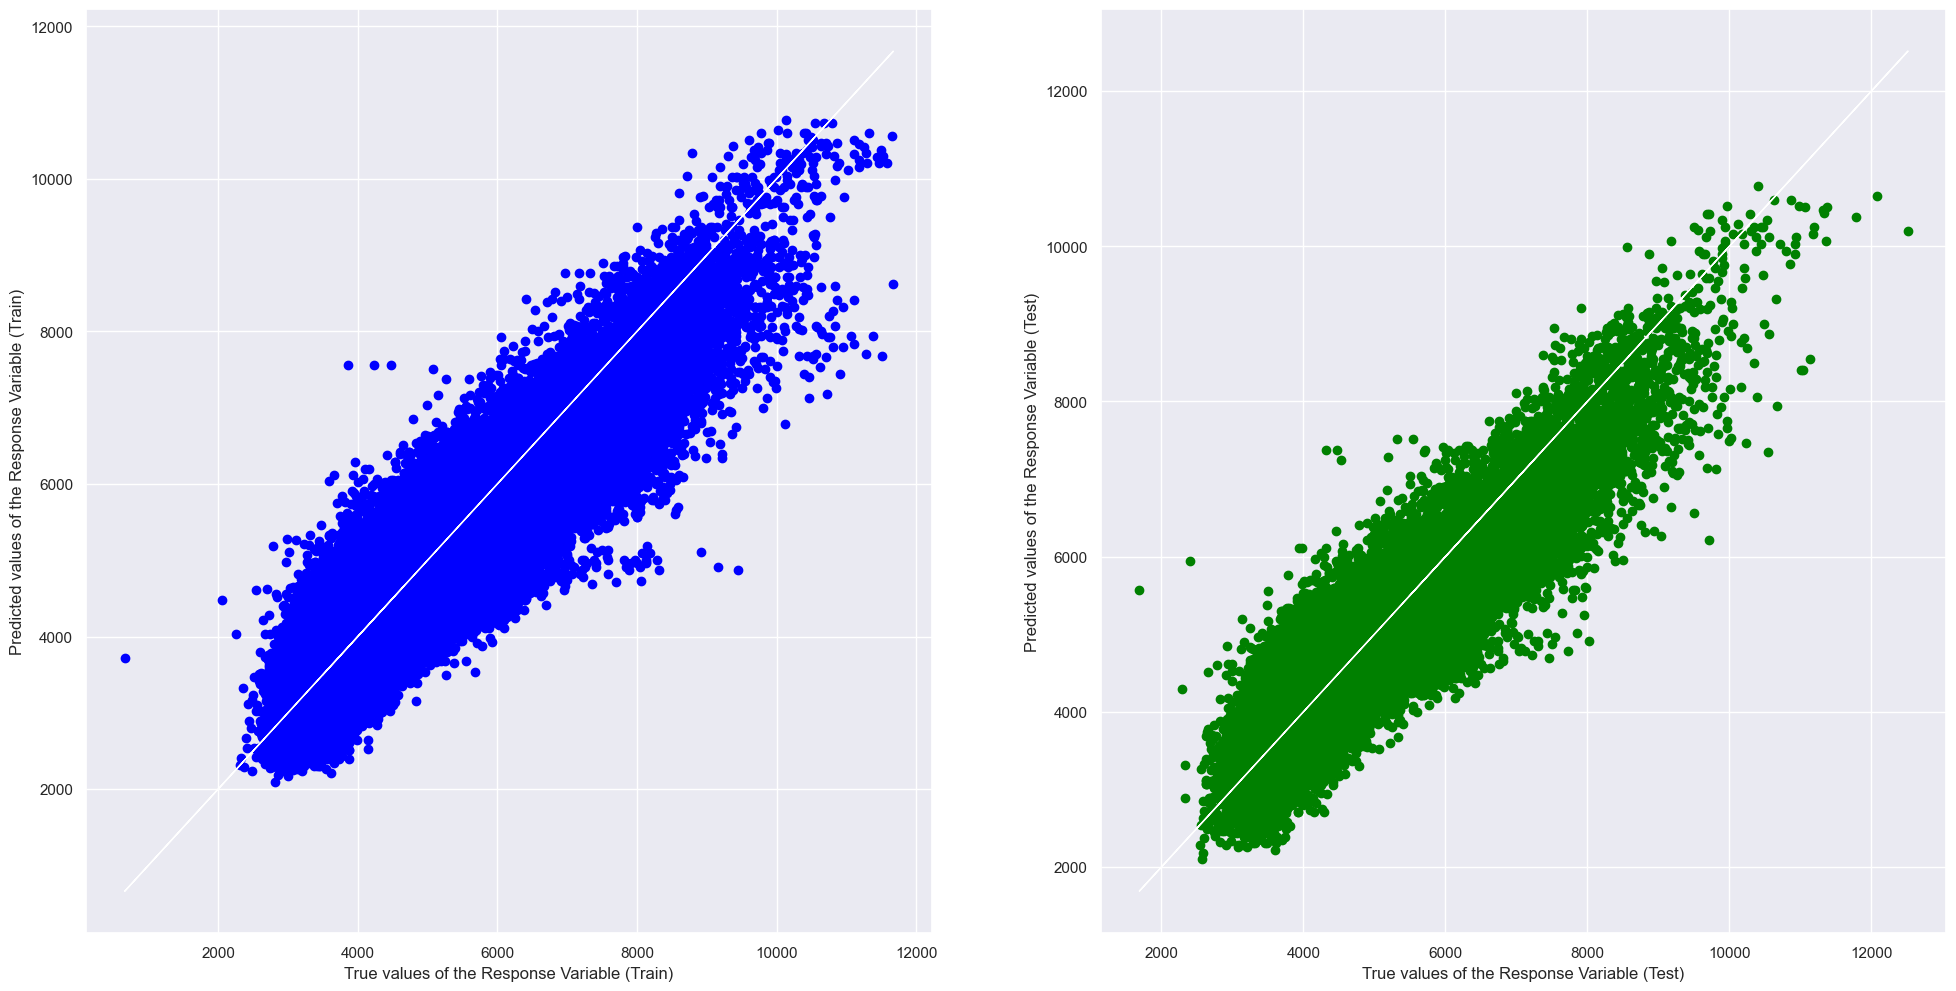

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.7919762167832819
Mean Squared Error (MSE) 	: 277738.3712719313

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.7921915216697158
Mean Squared Error (MSE) 	: 278531.1345361632



In [23]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train_encoded, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test_encoded, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

## Machine Learning Algorithm Improvement (regression in specific groups)

#### The results from our trained model is very good, with an R2 score of 0.79. This could be unusual, since we trained the model on the entire dataset across different towns, flat types, etc. 
#### From domain knowledge, resale flat prices should vary across different towns. Also, flat prices should vary across different flat types as well. We would like to study this deeper.
#### Let us group the dataset based on town and flat type, and check the distribution of data points in each group.

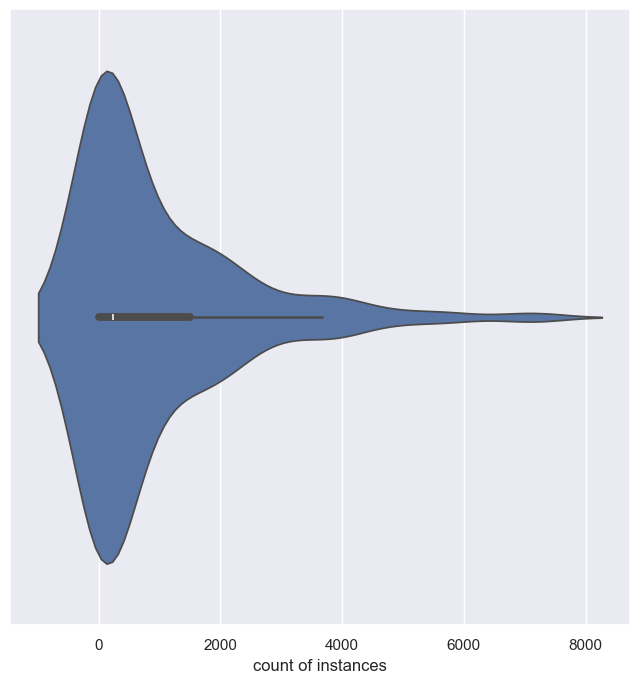

In [24]:
groupedHDB_data = []
for town in HDB_subdata['town'].unique():
    for flat_type in HDB_subdata['flat_type'].unique():
        count = len(HDB_subdata[(HDB_subdata['town'] == town) & 
                                (HDB_subdata['flat_type'] == flat_type)])
        groupedHDB_data.append([town, flat_type, count])

groupedHDB_df = pd.DataFrame(groupedHDB_data, columns=['town', 'flat_type', 'count of instances'])

f = plt.figure(figsize=(8,8))
sb.violinplot(data = groupedHDB_df,x = 'count of instances',palette='deep');

#### It seems that the distribution of data points are clustered around ~200, and majority of groups have no data points. Grouping by town and flat_type may not be useful as it would be unfair to compare the R2 and MSE of groups with smaller and larger number of data points. Also, we will be omitting many groups from the analysis as a result of grouping.
#### We do not need the previous lists and dataframes with grouped town and flat type data anymore, so let's just replace them.

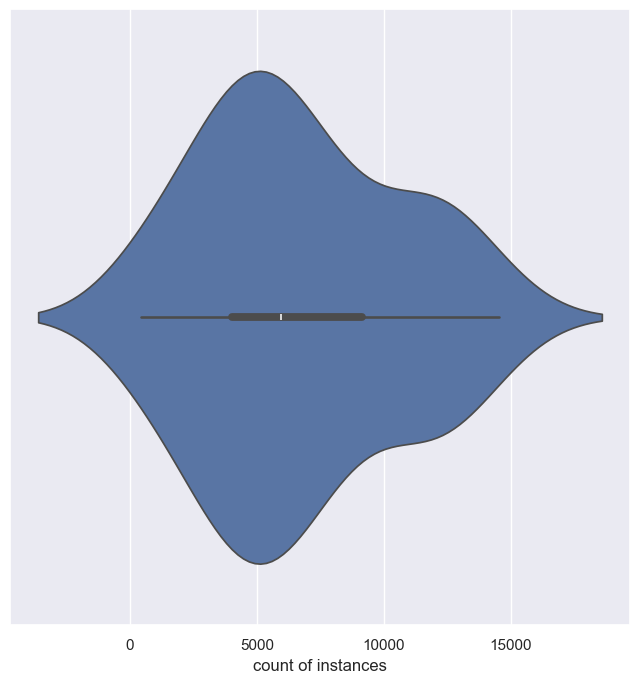

In [25]:
groupedHDB_data = []
for town in HDB_subdata['town'].unique():
        count = len(HDB_subdata[(HDB_subdata['town'] == town)])
        groupedHDB_data.append([town, count])

groupedHDB_df = pd.DataFrame(groupedHDB_data, columns=['town', 'count of instances'])

f = plt.figure(figsize=(8,8))
sb.violinplot(data = groupedHDB_df,x = 'count of instances',palette='deep');

In [26]:
groupedHDB_df['count of instances'].describe()

count       26.000000
mean      6705.807692
std       3898.296438
min        441.000000
25%       4023.000000
50%       5964.000000
75%       9147.000000
max      14522.000000
Name: count of instances, dtype: float64

#### The distribution of data points by grouping the dataset with just 'town' seems more reasonable this time around. There are also no groups with 0 data points, looking at the minimum.

#### To reduce the number of categorical variables in the new regression model, we convert storey_range into a numerical variable by taking the mid-point of the storeys. This removes the problem of encoding the categorical variable 'storey_range'.
#### For example, if storey_range == '01 TO 03', convert it into a new variable dummy_storey_range == 2

In [27]:
def cal_num_storey_range(row):
    lower_bound, upper_bound = map(int, row.split(' TO '))
    return int((lower_bound + upper_bound) / 2)

# Apply the custom function to each cell in the column
HDB_subdata['numerical_storey_range'] = HDB_subdata['storey_range'].apply(cal_num_storey_range)
HDB_subdata.head()

,month,town,flat_type,block,street_name,storey_range,flat_model,discretized_remaining_lease,final_norm_price,numerical_storey_range
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,Improved,23,5272.727273,11
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,New Generation,22,3731.343284,2
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,New Generation,24,3910.447761,2
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,New Generation,23,3897.058824,5
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,New Generation,24,3955.223881,2


#### Train the regression model for each combination of ('town', 'flat_type'). 
#### We will only conduct regression for towns with datapoints > median # of data points across all towns.
#### Y1 = final_norm_price
#### X1 = 'flat_model', 'numerical_storey_range','discretized_remaining_lease'

In [28]:
collectdata = []
models = {}
prefix = 'model_'
x = 1


for town in HDB_subdata['town'].unique():
    temp_df = HDB_subdata[(HDB_subdata['town'] == town)]
    
    model_name = prefix + str(x)
    
    X1 = temp_df[['numerical_storey_range', 'flat_model', 'discretized_remaining_lease']]
    y1 = temp_df['final_norm_price']
            
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.25,random_state=42)
            
    # Perform simple dummy encoding for categorical columns in training set, using drop_first to account for dummy variable trap
    X1_train_encoded = pd.get_dummies(X1_train, columns=['flat_model'],drop_first=True)

    # Perform simple dummy encoding for categorical columns in testing set, using drop_first to account for dummy variable trap
    X1_test_encoded = pd.get_dummies(X1_test, columns=['flat_model'],drop_first=True)
            
    linreg = LinearRegression()
    linreg.fit(X1_train_encoded, y1_train)
    models[model_name] = linreg
            
    y1_train_pred = linreg.predict(X1_train_encoded)
    y1_test_pred = linreg.predict(X1_test_encoded)
            
    Rsquared_train = linreg.score(X1_train_encoded, y1_train)
    Rsquared_test = linreg.score(X1_test_encoded, y1_test)
            
    MSE_train = mean_squared_error(y1_train, y1_train_pred)
    MSE_test = mean_squared_error(y1_test, y1_test_pred)
        
    data_points = len(temp_df)
    
    collectdata.append([model_name, town, data_points, Rsquared_train, Rsquared_test, MSE_train, MSE_test])
    x += 1

## Town-grouped Regression Model Metrics Analysis

#### Let's analyse the training and testing R2 and MSE across the towns.

In [29]:
data_metrics = pd.DataFrame(collectdata, columns = ['model_no','town', 'data points', 'Train_R2','Test_R2','Train_MSE','Test_MSE'])
data_metrics.head()

,model_no,town,data points,Train_R2,Test_R2,Train_MSE,Test_MSE
0,model_1,ANG MO KIO,7216,0.857625,0.864850,175556.806746,175944.998140
1,model_2,BEDOK,9274,0.699218,0.703640,204568.392612,202699.785331
2,model_3,BISHAN,3190,0.711894,0.699475,258657.561192,274972.250788
3,model_4,BUKIT BATOK,6505,0.764917,0.759944,119191.152557,114995.999025
4,model_5,BUKIT MERAH,6679,0.750563,0.760768,608022.664070,602839.030907


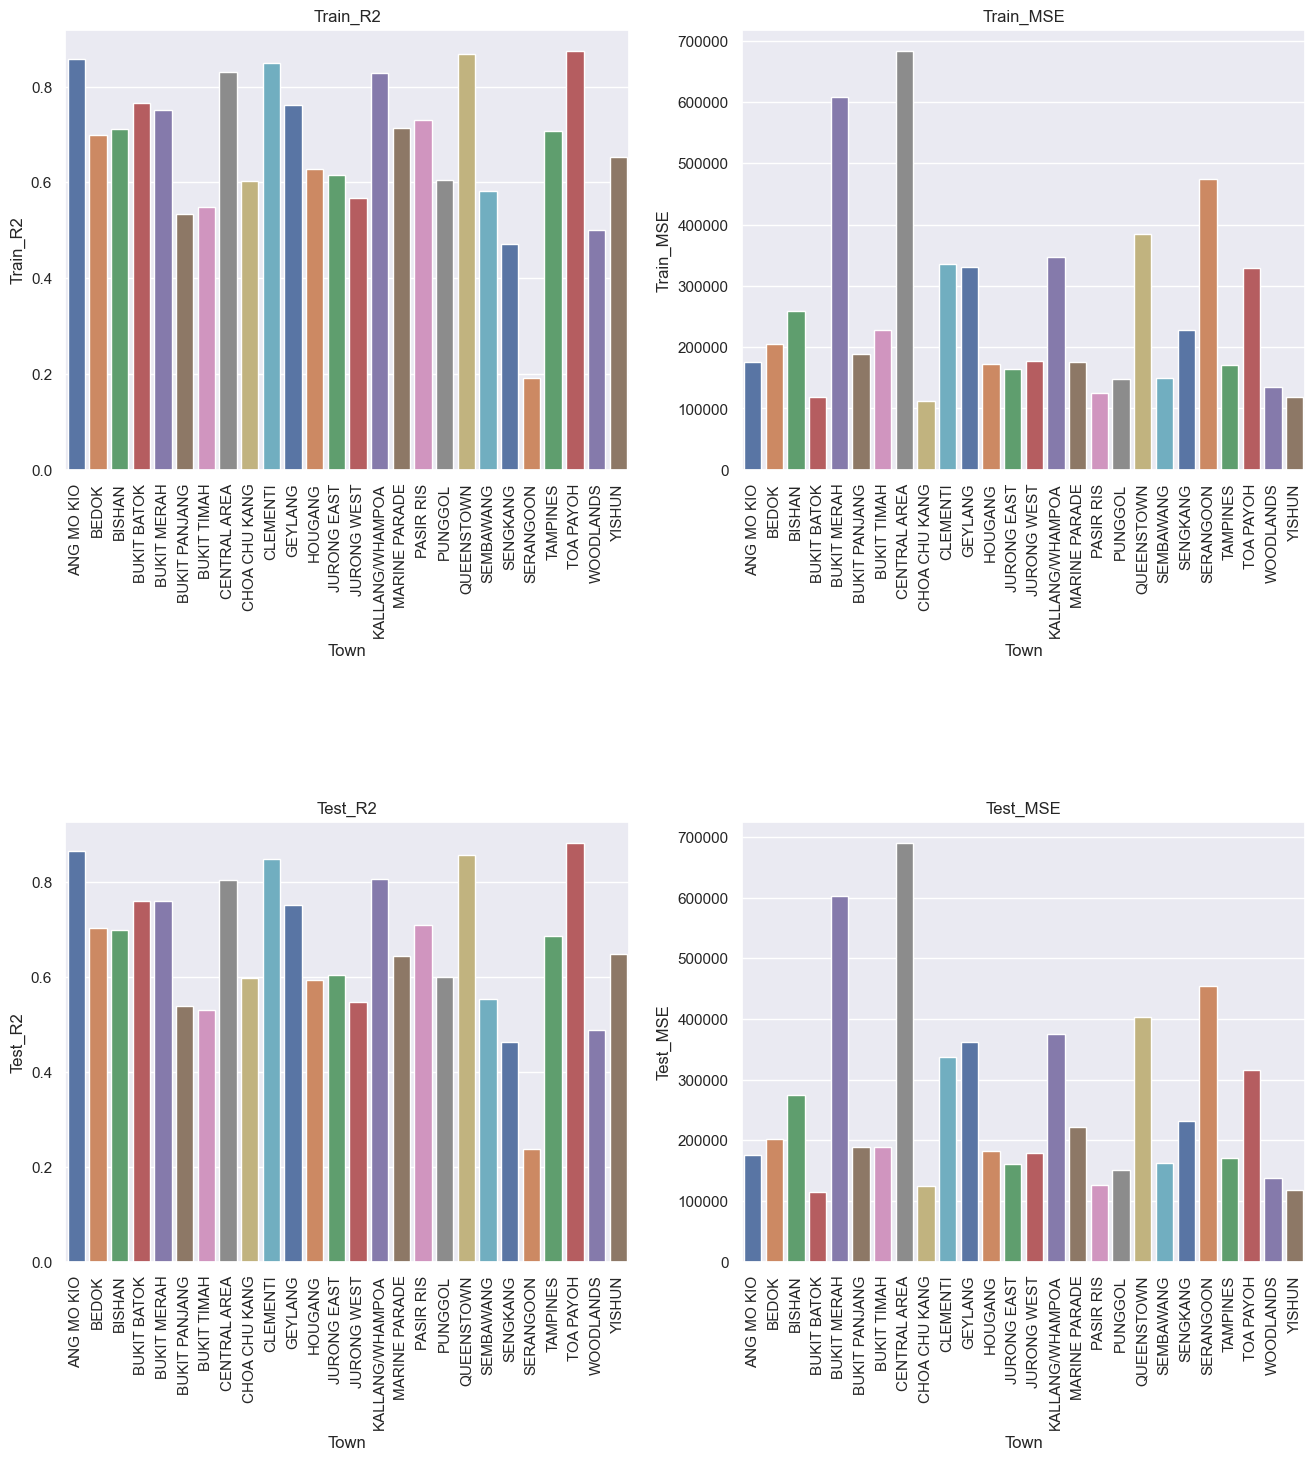

In [30]:
f,axes = plt.subplots(2,2,figsize=(16,16))

# Common parameters
palette = 'deep'
metrics = ['Train_R2', 'Train_MSE', 'Test_R2', 'Test_MSE']

# Plotting
for ax, metric, title in zip(axes.flatten(), metrics, metrics):
    ax = sb.barplot(data=data_metrics, x='town', y=metric, errorbar=None, ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlabel('Town')
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) # plt.xtick(rotation=90) did not work

plt.subplots_adjust(hspace=0.8)

#### As expected, model performance across different towns vary, with some having a low R2. This implies that flat price variation in each town is different, which confirms our logical understanding.
#### We continue analysing the metrics as well as the general relationship between MSE and R2.

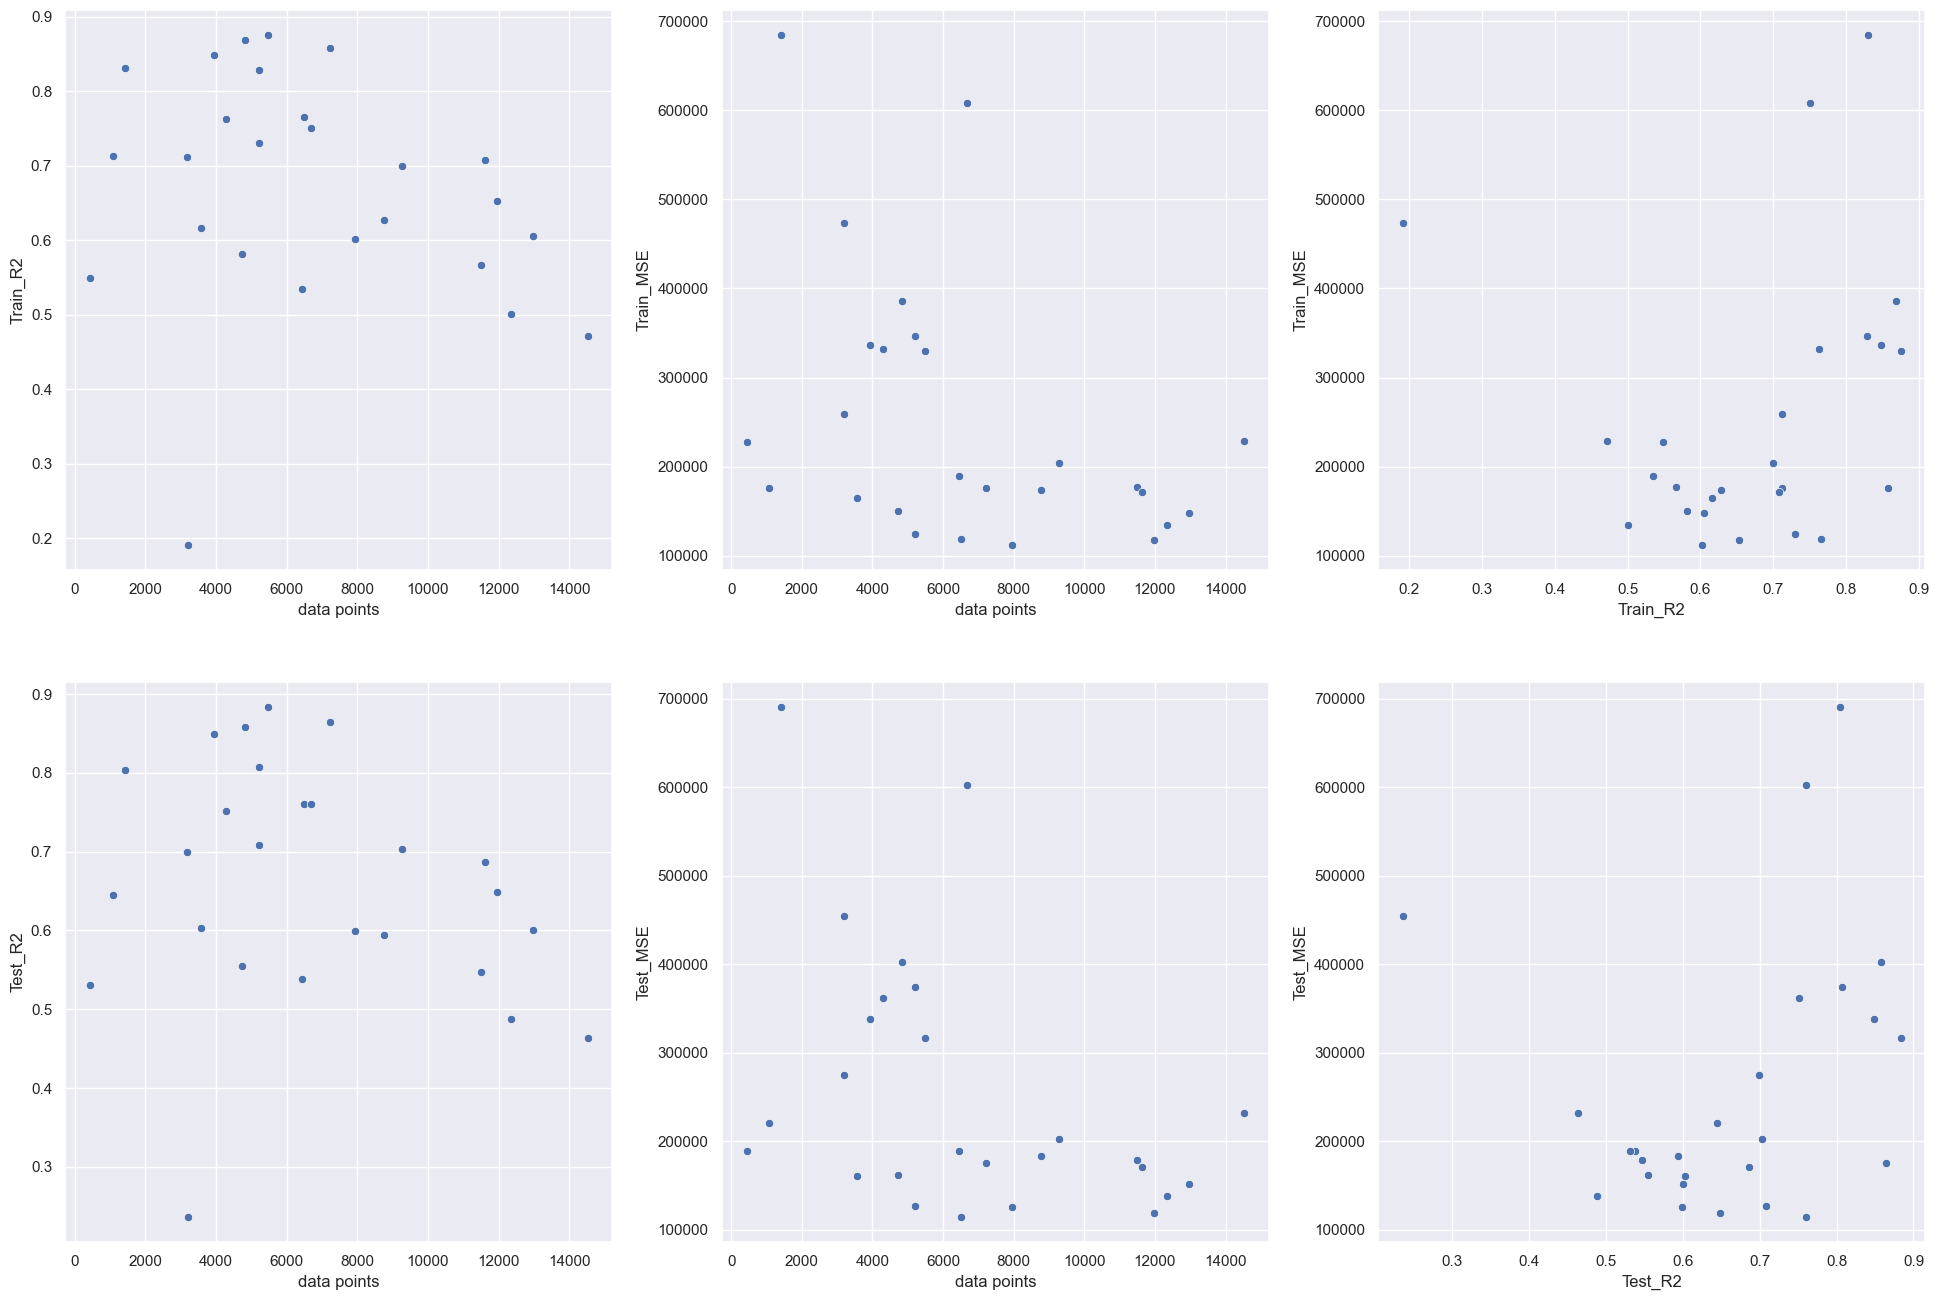

In [31]:
f, axes = plt.subplots(2,3,figsize=(24,16))
sb.scatterplot(data = data_metrics,x = 'data points',y = 'Train_R2', ax = axes[0,0],palette='deep');
sb.scatterplot(data = data_metrics,x = 'data points',y = 'Train_MSE', ax = axes[0,1],palette='deep');
sb.scatterplot(data = data_metrics,x = 'Train_R2',y = 'Train_MSE', ax = axes[0,2]);
sb.scatterplot(data = data_metrics,x = 'data points',y = 'Test_R2', ax = axes[1,0],palette='deep');
sb.scatterplot(data = data_metrics,x = 'data points',y = 'Test_MSE', ax = axes[1,1],palette='deep');
sb.scatterplot(data = data_metrics,x = 'Test_R2',y = 'Test_MSE', ax = axes[1,2]);

## Conclusion (contribution breakdown)
#### 1. Jackson: Application of ML model for entire dataset, and dataset grouped by town
#### 2. Titus: Data Cleaning & Pre-Processing, Addressing dummy variable trap during variable encoding
#### 3. Both: Metrics analysis + Limitations & Future Work

## Code Appendix 

## Limitations of Analysis and/or Predictions (Code used in Report)

#### Limitation #1: Underrepresented categories in town, flat type, flat model and storey range variables

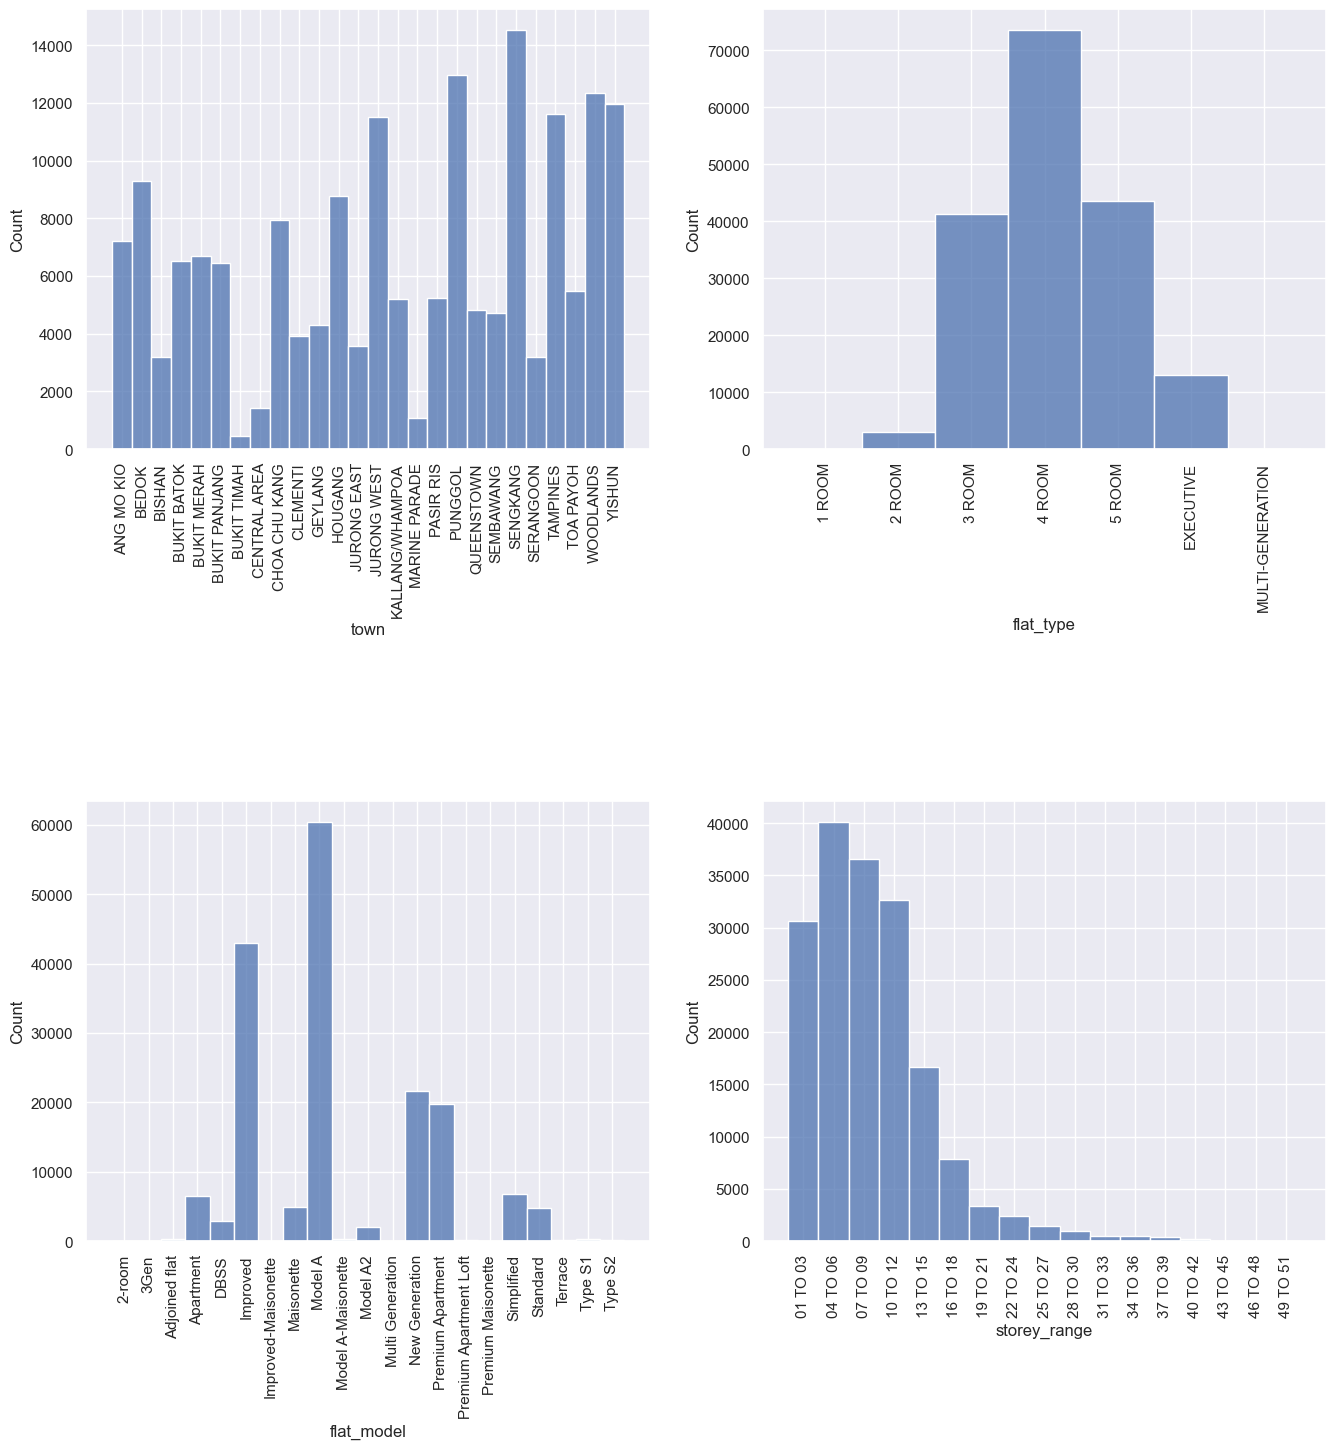

In [32]:
f, axes = plt.subplots(2,2,figsize=(16,16))
vars = ['town','flat_type','flat_model','storey_range']
r = 0
c = r
for var in vars:
    ax = sb.histplot(data = HDB_subdata,x = var,palette='deep',ax = axes[r,c])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    c += 1
    if c == 2:
        c = 0
        r += 1

plt.subplots_adjust(hspace=0.8)

#### Other limitations:
#### 1. Additional predictors of resale flat prices not available. Examples: proximity to top schools, average/median income of home owner.
#### 2. When conducting regression within each town, some have both high R2 and MSE in training and testing steps. This leads to those towns having poor price predictions. Solutions to this could be using DecisionTreeRegressor to consider possible non-linear relationships, or find better predictors and run a simple linear/multivariate linear regression again.